# Carnet d'ordre Markovien simplifié

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import default_rng
rng = default_rng()

['beta', 'binomial', 'bytes', 'chisquare', 'choice', 'dirichlet', 'exponential', 'f', 'gamma', 'geometric', 'gumbel', 'hypergeometric', 'integers', 'laplace', 'logistic', 'lognormal', 'logseries', 'multinomial', 'multivariate_hypergeometric', 'multivariate_normal', 'negative_binomial', 'noncentral_chisquare', 'noncentral_f', 'normal', 'pareto', 'permutation', 'permuted', 'poisson', 'power', 'random', 'rayleigh', 'shuffle', 'standard_cauchy', 'standard_exponential', 'standard_gamma', 'standard_normal', 'standard_t', 'triangular', 'uniform', 'vonmises', 'wald', 'weibull', 'zipf']


In [1]:
# def liste_methodes(obj): 
#     return [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]

In [44]:
# from inspect import getsource
# print(getsource(FuncAnimation))

### Carnet d'ordre

In [3]:
class Queue:
    def __init__(self, valeur_initiale=10, side='bid', prix=100):
        self.q = valeur_initiale
        self.prix = prix
        self.side = side
    
    def event(self, ordre):
        if ordre.get_type() == 'mkt':
            if self.q > 0:
                self.q -= 1
            else:
                self.q = 10  # Reset avec la quantité par défaut
        elif ordre.get_type() == 'limit':
            self.q += 1
        elif ordre.get_type() == 'cancel':
            if self.q > 0:
                self.q -= 1

    def __str__(self):
        return f'Best {self.side}, taille: {self.q}, prix: {self.prix}'

In [69]:
class Carnet:
    def __init__(self):
        self.qa = Queue(valeur_initiale=10, side='ask', prix=101)
        self.qb = Queue(valeur_initiale=10, side='bid', prix=100)
        
        self.fig, self.ax = plt.subplots(figsize=(6,4))
        self.x_range = np.arange(self.qb.prix - 10, self.qa.prix + 11)
        
    def actualiser(self):
        if self.qa.q == 0:
            self.qa = Queue(valeur_initiale=10, side='ask', prix=self.qb.prix + 2)
            self.qb = Queue(valeur_initiale=10, side='bid', prix=self.qb.prix + 1)

        if self.qb.q == 0:
            self.qb = Queue(valeur_initiale=10, side='bid', prix=self.qa.prix - 2)
            self.qa = Queue(valeur_initiale=10, side='ask', prix=self.qa.prix - 1)

    def evenement(self, ordre):
        if ordre.get_sens() == 'achat':
            self.qa.event(ordre)
        else:
            self.qb.event(ordre)

        self.actualiser()  # S'assure que les prix sont ajustés après chaque événement

    def __str__(self):
        mid = 0.5 * (self.qb.prix + self.qa.prix)
        return f'{self.qb} \n{self.qa} \nmid = {mid:.1f}'
    
    def plot(self):
        self.ax.clear()
        prix_bid = self.qb.prix
        prix_ask = self.qa.prix
        qte_bid = self.qb.q
        qte_ask = self.qa.q
        
        pk = np.zeros_like(self.x_range)
        pk[self.x_range == prix_bid] = qte_bid
        pk[self.x_range == prix_ask] = qte_ask

        self.ax.bar(self.x_range, pk, edgecolor="black", color="red", width=0.8, alpha=0.2)
        for i in range(len(self.x_range)):
            if pk[i] > 0:
                self.ax.text(self.x_range[i], pk[i] + 0.5, str(pk[i]), ha='center', va='bottom')
        self.ax.set_ylabel("Taille")
        self.ax.set_xlabel("Prix")
        self.ax.set_ylim(0, 15)
        self.ax.plot()
        
    def get_fig(self):
        return self.fig

In [70]:
class Ordre:
    def __init__(self, order_type='mkt', sens='achat'):
        self.order_type = order_type
        self.sens = sens

    def get_type(self):
        return self.order_type
    
    def get_sens(self):
        return self.sens
    
    def __str__(self):
        return f'Ordre {self.order_type} de {self.sens}'

<IPython.core.display.Javascript object>


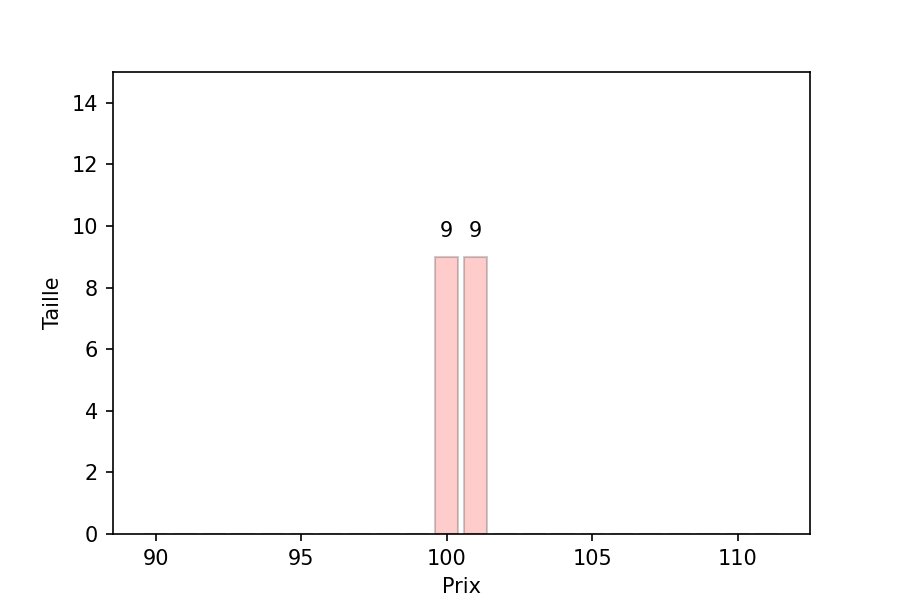

Best bid, taille: 9, prix: 100 
Best ask, taille: 9, prix: 101 
mid = 100.5


In [71]:
# Exemple d'utilisation
carnet = Carnet()
ordre_achat = Ordre('mkt', 'achat')
ordre_vente = Ordre('mkt', 'vente')
carnet.evenement(ordre_achat)
carnet.evenement(ordre_vente)
print(carnet)
carnet.plot()

In [72]:
# best ask consommé -> décalage du mid
for k in range(9):
    ordre = Ordre('limit', 'achat')
    carnet.evenement(ordre)
print(carnet)

Best bid, taille: 9, prix: 100 
Best ask, taille: 18, prix: 101 
mid = 100.5


### Arrivée dynamique des ordres

In [73]:
# paramètres 
lambd = 102
mu_plus_theta = 104

In [74]:
proba = lambd / (lambd + mu_plus_theta)

def generate_events(lambd, mu_plus_theta, T):

    jump_times = []
    sides = []
    
    # Temps initial
    t = 0
    
    # Générer les instants de sauts
    while t < T:
        # Générer le temps du prochain saut selon une distribution exponentielle
        time_to_next_jump = rng.exponential(lambd + mu_plus_theta)
        
        # Mettre à jour le temps
        t += time_to_next_jump
        
        # Si le temps du prochain saut est inférieur à T, ajouter à la liste
        if t < T:
            jump_times.append(t)
            sides.append(rng.choice([-1, 1], p=[proba, 1-proba]))
            
    
    return jump_times, sides

serie = generate_events(lambd, mu_plus_theta, 10000)
# print(serie)

<IPython.core.display.Javascript object>


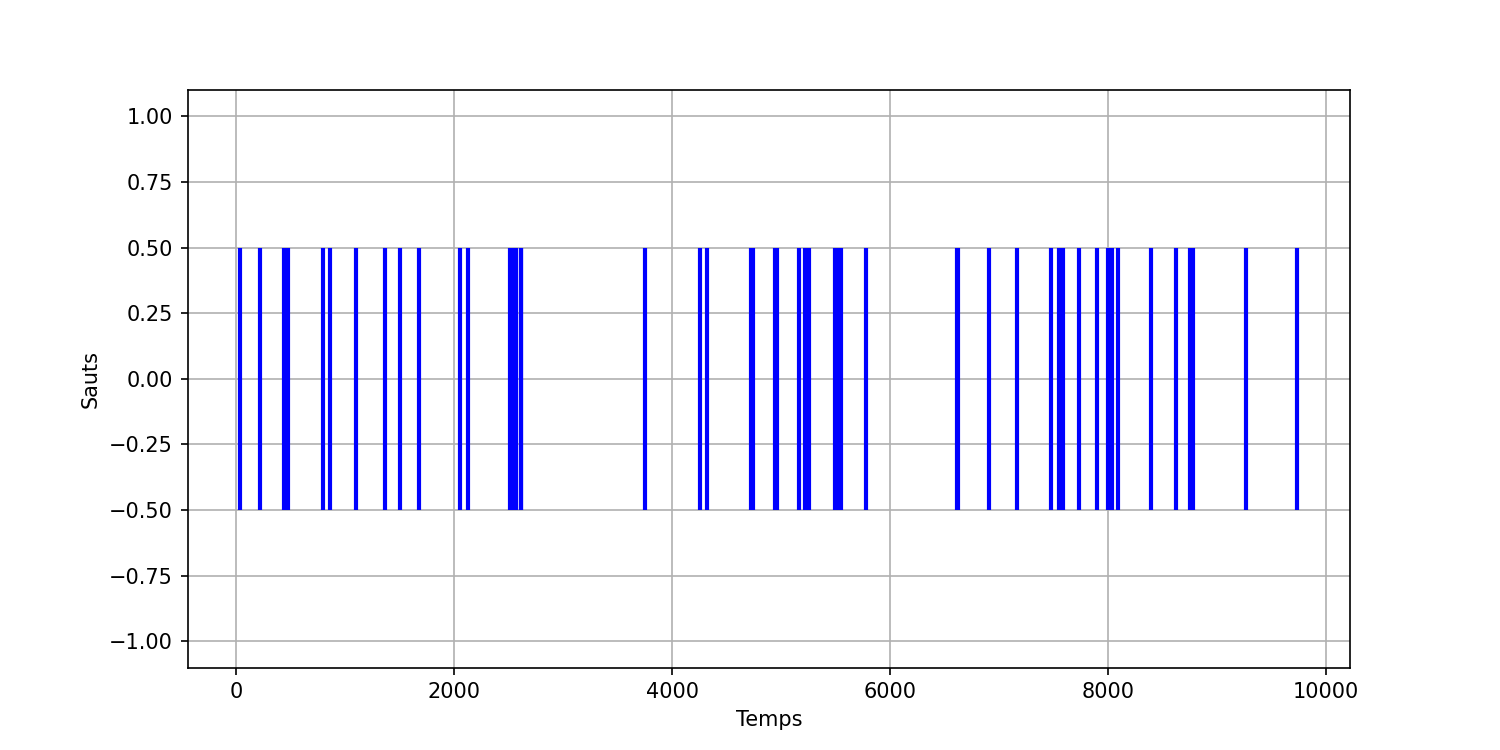

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.eventplot(serie[0], lineoffsets=0, colors='b', linewidths=2)
plt.xlabel('Temps')
plt.ylabel('Sauts')
plt.grid(True)
plt.show()

In [76]:
# on génère une série d'ordres pour chaque type d'ordre (les séries sont indépendantes)

T = 10000

serie_mkt = generate_events(lambd, mu_plus_theta, T)
serie_limit = generate_events(lambd, mu_plus_theta, T)
serie_cancel = generate_events(lambd, mu_plus_theta, T)

In [77]:
def fusionner(series, etiquettes):
    donnees = []
    
    if len(series) != len(etiquettes):
        raise ValueError("Le nombre d'étiquettes doit correspondre au nombre de séries.")
    
    for etiquet, (temps, valeurs) in zip(etiquettes, series):
        donnees.extend([(t, v, etiquet) for t, v in zip(temps, valeurs)])
    
    # Créer un DataFrame à partir de la liste des données
    df = pd.DataFrame(donnees, columns=['Temps', 'Sens', 'Type'])
    # Trier le DataFrame par temps
    df = df.sort_values(by='Temps').reset_index(drop=True)
    return df

types_ordres = ['mkt', 'limit', 'cancel']

# Fusionner et trier les séries
series = [serie_mkt, serie_limit, serie_cancel]
order_flow = fusionner(series, types_ordres)
order_flow['Sens'] = order_flow['Sens'].replace({1: 'achat', -1: 'vente'})
order_flow.head()

,Temps,Sens,Type
0,60.094239,achat,limit
1,160.408466,achat,mkt
2,300.514193,achat,limit
3,337.199397,achat,limit
4,466.388657,achat,mkt


In [78]:
order_flow.shape

(145, 3)

<IPython.core.display.Javascript object>


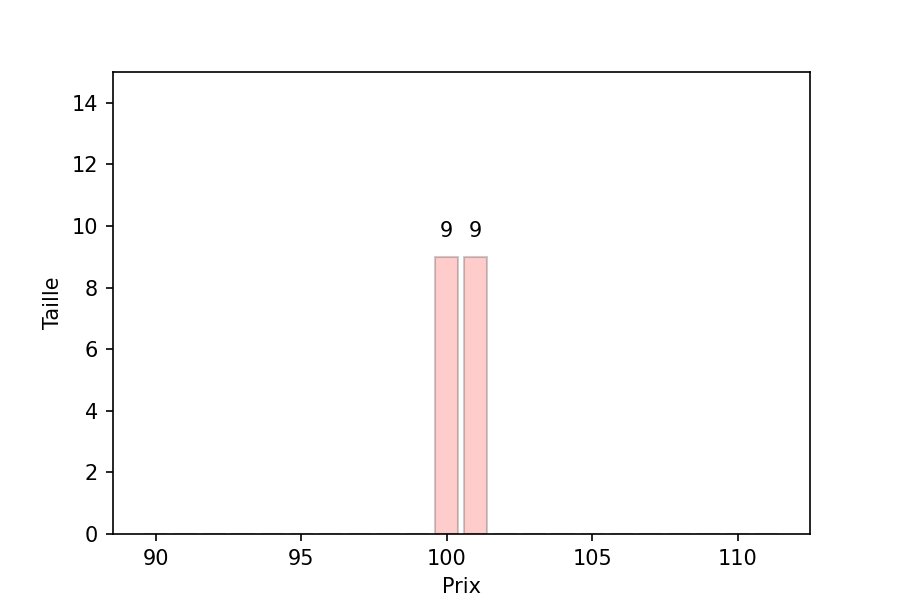

In [81]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

carnet = Carnet()

# Fonction de mise à jour de l'animation
def update(frame):
    ordre = Ordre(*frame)
    carnet.evenement(ordre)
    carnet.plot()
    return carnet.ax.figure

# Création de l'animation
fig = carnet.get_fig()
custom_intervals = order_flow[['Temps']].diff(1).dropna().values.flatten()
frames = order_flow[['Type', 'Sens']].values

def animate(i):
    update(frames[i])
    plt.pause(custom_intervals[i] / 1000)  # Pause pour l'intervalle de temps personnalisé

ani = FuncAnimation(fig, animate, frames=len(frames), blit=False)
# ani = FuncAnimation(fig, update, frames, blit=True, interval = custom_intervals)

# Affichage de l'animation
plt.show()
